In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

event_id = os.getcwd().split('/')[-3]
print(f'EVENT: {event_id}')

base_dir = f"/data/des70.a/data/desgw/O4/{event_id}/gw_workflow/"

with open(base_dir+'dagmaker.rc') as rcfile:
    for line in rcfile.readlines():
        if 'SEASON' in line:
            season = int(line[-5:-1])
            print(f'SEASON: {season}')

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

EVENT: S240511i
SEASON: 1550


<h2>Finding Exposures</h2>

In [2]:
search_expnums = []
for filename in glob(base_dir+f'../exposures/*/{event_id}_exposures.list'):
    search_expnums = np.append(search_expnums, np.loadtxt(filename))
search_expnums = np.unique(search_expnums).astype(int)

search_commands = []
search_bands = []
search_nites = []
for expnum in search_expnums:
    with open(base_dir+f'desgw_pipeline_{expnum}.dag') as dagfile:
        p_counter = 0
        s_counter = 0
        for i, line in enumerate(dagfile):
            if line.strip()=='<parallel>' or line.strip()=='</parallel>':
                p_counter += 1
            elif line.strip()=='<serial>':
                s_counter += 1
            elif p_counter==3:
                search_nites.append(line.split()[32])
                search_bands.append(line.split()[30])
                search_commands.append(line)
                p_counter += 1
print('Total Search Images:', len(search_expnums))

Total Search Images: 297


In [3]:
template_expnums = []
template_commands = []
template_nites = []

for expnum in search_expnums:
    with open(base_dir+f'desgw_pipeline_{expnum}.dag') as dagfile:
        for i, line in enumerate(dagfile):
            if i<2:
                continue
            if line.strip()=='</parallel>':
                break
            template_nites.append(line.split()[37])
            template_expnums.append(line.split()[31])
            template_commands.append(line)

print('Total Templates:', len(template_expnums))
template_expnums, unique_idx = np.unique(template_expnums, return_index=True)
template_commands = np.array(template_commands)[unique_idx]
template_nites = np.array(template_nites)[unique_idx]
print('Unique Templates:', len(template_expnums))

Total Templates: 14520
Unique Templates: 1638


In [4]:
# TEMPLATES
n_templates = len(template_expnums)
pass_ccds = 0
ccds_per_template = np.zeros(n_templates, dtype=int)
for i in range(n_templates):
    path = '/pnfs/des/persistent/gw/exp/{}/{}/'.format(template_nites[i], template_expnums[i])
    for file in glob(path+'*r4p12_ZP.csv'):
        pass_ccds += 1
        ccds_per_template[i] += 1
next_pass_template_idxs = np.arange(n_templates)[ccds_per_template<40][1:]
print('Total Completed CCDs: {}/{} ({:.1%})'.format(pass_ccds, n_templates*60, pass_ccds/(n_templates*60)))
print(f'{len(next_pass_template_idxs)} Templates with less than 58 completed CCDs')

Total Completed CCDs: 74133/98280 (75.4%)
388 Templates with less than 58 completed CCDs


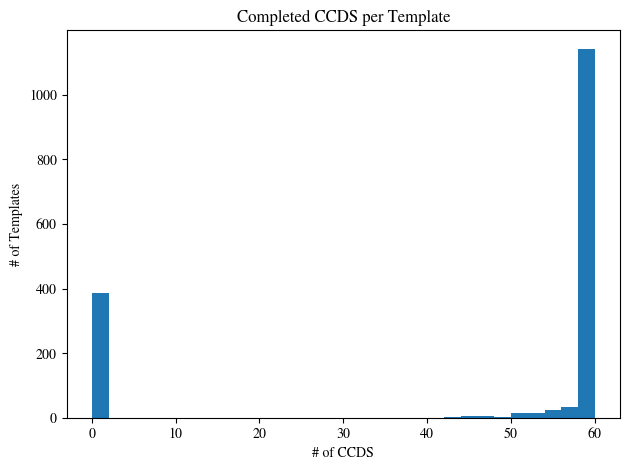

In [5]:
fig, ax = plt.subplots()
ax.hist(ccds_per_template, bins=30)
ax.set_title('Completed CCDS per Template')
ax.set_xlabel('# of CCDS')
ax.set_ylabel('# of Templates')
fig.tight_layout()

<h2>Post-Processing Analysis</h2>

In [6]:
search_failfiles = []
search_outfiles = []
failtype = []
for i in range(len(search_expnums)):
    list_outfiles = glob(f'/pnfs/des/persistent/gw/exp/{search_nites[i]}/{search_expnums[i]}/dp{season}/*/*.gz')
    if len(list_outfiles) > 0:
        search_outfiles.append(len(list_outfiles))
        list_failfiles = glob(f'/pnfs/des/persistent/gw/exp/{search_nites[i]}/{search_expnums[i]}/dp{season}/*/*.FAIL')
        for i in range(len(list_failfiles)):
            failtype.append(list_failfiles[i].split('/')[-1].split('_')[0])
        if len(list_failfiles) > 0:
            search_failfiles.append(len(list_failfiles))
        else:
            search_failfiles.append(0)
    else:
        search_outfiles.append(0)
        search_failfiles.append(0)

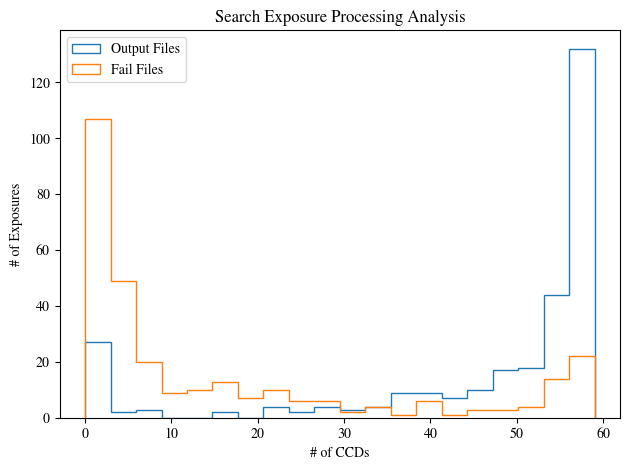

In [7]:
fig, ax = plt.subplots()
ax.hist(search_outfiles, bins=20, histtype='step', label='Output Files')
ax.hist(search_failfiles, bins=20, histtype='step', label='Fail Files')
ax.set_xlabel('# of CCDs')
ax.set_ylabel('# of Exposures')
ax.set_title('Search Exposure Processing Analysis')
ax.legend()
fig.tight_layout()

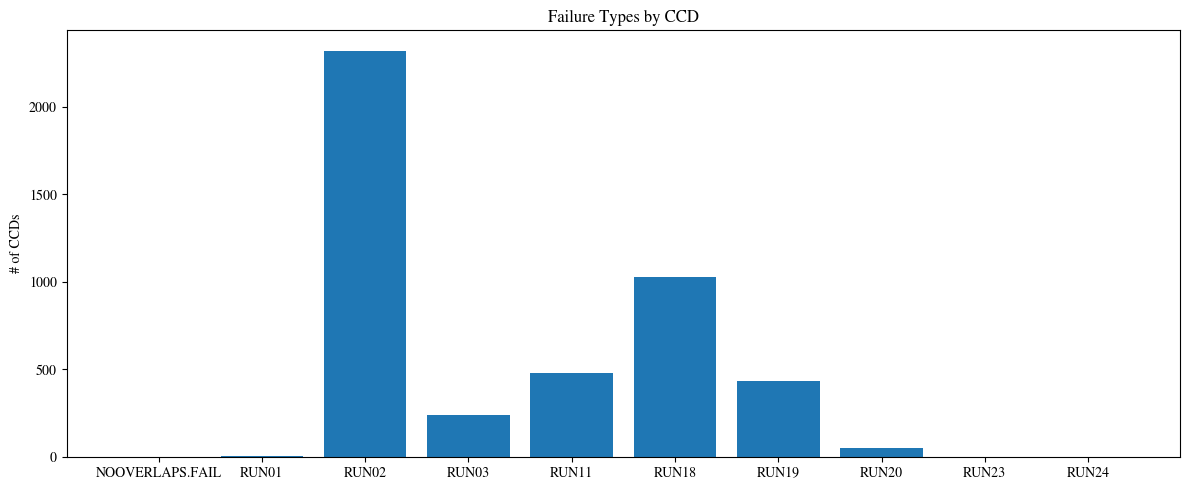

In [8]:
failnames, failnums = np.unique(failtype, return_counts=True)

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(failnames, failnums)
ax.set_ylabel('# of CCDs')
ax.set_title('Failure Types by CCD')
fig.tight_layout()

In [9]:
print('{:.0%} output rate, {:.0%} fail rate, {:.0%} success rate'.format(
    np.sum(search_outfiles)/(np.max(search_outfiles)*len(search_outfiles)),
    np.sum(search_failfiles)/(np.max(search_outfiles)*len(search_outfiles)),
    (np.sum(search_outfiles)-np.sum(search_failfiles))/(np.max(search_outfiles)*len(search_outfiles)))) 

79% output rate, 26% fail rate, 53% success rate


In [10]:
# Search Exposures with less than 40 pipeline output .gz files

np.sort(np.array(search_expnums)[np.array(search_outfiles)<40])

array([1297786, 1297788, 1297795, 1297801, 1297802, 1297804, 1297805,
       1297809, 1297810, 1297811, 1297813, 1297814, 1297816, 1297821,
       1297823, 1297828, 1298499, 1298501, 1298507, 1298514, 1298520,
       1298522, 1298525, 1298534, 1298535, 1298538, 1298539, 1298541,
       1299808, 1299810, 1299811, 1299813, 1299814, 1299815, 1299819,
       1299834, 1299837, 1300115, 1300116, 1300119, 1300124, 1300127,
       1300132, 1300138, 1300153, 1300173, 1300181, 1300185, 1300186,
       1300202, 1304665, 1304666, 1304677, 1304678, 1304679, 1304697,
       1304706, 1304708, 1304710, 1304713, 1304714, 1304720, 1304721,
       1304724, 1304730])